In [2]:
!pip install monpa

     |████████████████████████████████| 8.5 MB 5.0 MB/s 


### Import package

In [3]:
import pandas as pd
import numpy as np
import csv
import datetime

import warnings
warnings.filterwarnings("ignore")

import monpa
from monpa import utils
import re

# 我們從stopwords_zh.txt這個檔案中匯入繁體中文的停用詞
with open('./bda2022_dataset/stopwords_zh.txt', 'r', encoding="utf8") as file: #
    stopwords = file.read().splitlines() 
file.close()

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


### Import data

In [5]:
stock = pd.read_excel('./bda2022_dataset/stock_data_2019-2021.xlsx', sheet_name = '上市2021')
bbs = pd.read_csv('./bda2022_dataset/bda2022_mid_bbs_2019-2021.csv')
forum_2019 = pd.read_csv('./bda2022_dataset/bda2022_mid_forum_2019.csv')
forum_2020 = pd.read_csv('./bda2022_dataset/bda2022_mid_forum_2020.csv')
forum_2021 = pd.read_csv('./bda2022_dataset/bda2022_mid_forum_2021.csv')
forum = pd.concat([forum_2019, forum_2020, forum_2021]).reset_index(drop=True)

In [6]:
def clearSentence(sentence):
    return re.sub(r'[^\u4e00-\u9fa5]+', '', sentence)

### # 元大台灣50 投資佔比 >1% 之股票

In [7]:
# coid = ["台積電", "聯發科", "鴻海", "聯電", "中信金", "台達電", "富邦金", 
#         "國泰金", "南亞", "台塑", "中華電", "中鋼", "兆豐金", "玉山金", 
#         "長榮", "日月光投控", "中租-KY", "開發金", "統一", "元大金", "第一金", "合庫金"]
coid = ["2330 台積電", "2454 聯發科", "2317 鴻海", "2317 聯電", "2891 中信金", "2308 台達電", 
        "2881 富邦金", "2882 國泰金", "1303 南亞", "1301 台塑", "2412 中華電", "2002 中鋼", 
        "2886 兆豐金", "2884 玉山金", "2603 長榮", "3711 日月光投控", "5871 中租-KY", 
        "2883 開發金", "1216 統一", "2885 元大金", "2892 第一金", "5880 合庫金"]

### Count how many pieces of news in bbs and forum for each stock

In [8]:
coName = []
for i in coid:
    coName.append(i[5:])
    
num_data = pd.DataFrame()
num_data['coName'] = coName

num_bbs = []
num_forum = []
# count = 0
for i in coName:
    # count += 1
    # if count % 100 == 0:
    #     print(count)
    num_bbs.append(bbs[bbs['title'].str.contains(i) | bbs['content'].str.contains(i)].shape[0])
    num_forum.append(forum[forum['title'].str.contains(i) | forum['content'].str.contains(i)].shape[0])

In [9]:
num_data['num_bbs'] = num_bbs
num_data['num_forum'] = num_forum
# num_data[(num_data.num_bbs > 1500) & (num_data.num_forum > 1500)]
num_data['total'] = num_data['num_bbs'] + num_data['num_forum']
num_data

,coName,num_bbs,num_forum,total
0,台積電,11630,19814,31444
1,聯發科,2192,1549,3741
2,鴻海,3361,7314,10675
3,聯電,3109,2213,5322
4,中信金,1150,1327,2477
5,台達電,668,383,1051
6,富邦金,1198,1237,2435
7,國泰金,1200,1493,2693
8,南亞,2121,1327,3448
9,台塑,1061,617,1678


### Sort the variation
\> 0.75 variation  =>  漲

< 0.25 variation  =>  跌

In [10]:
def price_label(coid, day):
    company = stock[stock['證券代碼'].str.contains(coid)]
    company['年月日'] = pd.to_datetime(company['年月日']).dt.date
    company = company.sort_values(by = '年月日').reset_index(drop = True)

    company = company[['證券代碼', '年月日', '收盤價(元)']]
    company['單日漲跌幅(%)'] = company['收盤價(元)'].rolling(window=day+1).apply(lambda x: (x.iloc[day]-x.iloc[0])/x.iloc[0])
    company['label'] = company['單日漲跌幅(%)'].apply(lambda x: (x>np.quantile(company['單日漲跌幅(%)'][day:], 0.75) and '漲') or (x<np.quantile(company['單日漲跌幅(%)'][day:], 0.25) and '跌') or "穩")
    
    return company

0050 元大台灣50


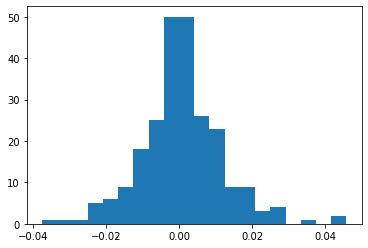

穩    122
漲     61
跌     61
Name: label, dtype: int64
0050 元大台灣50


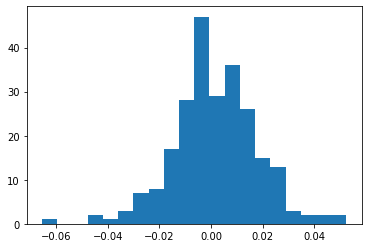

穩    122
漲     61
跌     61
Name: label, dtype: int64
0050 元大台灣50


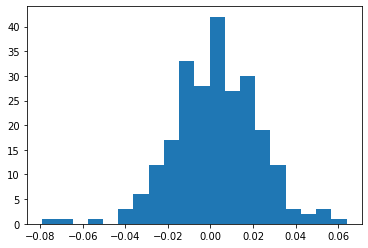

穩    124
漲     60
跌     60
Name: label, dtype: int64


In [11]:
# price_df[DAY] 往後看一天、兩天、三天的漲跌
Day = [1,2,3]
price_df = [pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]
for d in Day:
    price_df[d-1] = pd.concat([price_df[d-1], price_label('0050 元大台灣50',d)])
    plt.hist(price_df[d-1].loc[price_df[d-1].證券代碼 == '0050 元大台灣50', "單日漲跌幅(%)"], bins=20)
    print('0050 元大台灣50')
    plt.show()
    print(price_df[d-1].loc[price_df[d-1].證券代碼 == '0050 元大台灣50', "label"].value_counts())

In [12]:
price_df[0]

,證券代碼,年月日,收盤價(元),單日漲跌幅(%),label
0,0050 元大台灣50,2021-01-04,118.7821,NaN,穩
1,0050 元大台灣50,2021-01-05,119.0209,0.002010,穩
2,0050 元大台灣50,2021-01-06,120.3105,0.010835,漲
3,0050 元大台灣50,2021-01-07,123.1284,0.023422,漲
4,0050 元大台灣50,2021-01-08,125.3254,0.017843,漲
...,...,...,...,...,...
239,0050 元大台灣50,2021-12-24,139.9799,0.002805,穩
240,0050 元大台灣50,2021-12-27,141.0563,0.007690,漲
241,0050 元大台灣50,2021-12-28,142.1816,0.007978,漲
242,0050 元大台灣50,2021-12-29,142.8176,0.004473,穩


In [ ]:
price_df[1]

,證券代碼,年月日,收盤價(元),單日漲跌幅(%),label
0,0050 元大台灣50,2021-01-04,118.7821,NaN,穩
1,0050 元大台灣50,2021-01-05,119.0209,NaN,穩
2,0050 元大台灣50,2021-01-06,120.3105,0.012867,漲
3,0050 元大台灣50,2021-01-07,123.1284,0.034511,漲
4,0050 元大台灣50,2021-01-08,125.3254,0.041683,漲
...,...,...,...,...,...
239,0050 元大台灣50,2021-12-24,139.9799,0.008460,穩
240,0050 元大台灣50,2021-12-27,141.0563,0.010516,穩
241,0050 元大台灣50,2021-12-28,142.1816,0.015729,漲
242,0050 元大台灣50,2021-12-29,142.8176,0.012487,漲


In [ ]:
price_df[2]

,證券代碼,年月日,收盤價(元),單日漲跌幅(%),label
0,0050 元大台灣50,2021-01-04,118.7821,NaN,穩
1,0050 元大台灣50,2021-01-05,119.0209,NaN,穩
2,0050 元大台灣50,2021-01-06,120.3105,NaN,穩
3,0050 元大台灣50,2021-01-07,123.1284,0.036591,漲
4,0050 元大台灣50,2021-01-08,125.3254,0.052970,漲
...,...,...,...,...,...
239,0050 元大台灣50,2021-12-24,139.9799,0.008460,穩
240,0050 元大台灣50,2021-12-27,141.0563,0.016215,漲
241,0050 元大台灣50,2021-12-28,142.1816,0.018577,漲
242,0050 元大台灣50,2021-12-29,142.8176,0.020272,漲


### 篩出含目標股票們的文章並加上標籤

* 將第n天的文章與第 n+1 or n+2 or n+3 的股市漲跌標籤合併，並且只保留我們需要的欄位資訊

* <font color="dd0000">在這裡選擇要看隔幾天的漲跌</font>
    * 換天數改這裡就好，下面不用改，直接跑就好
    * Day = [1,2,3]

In [37]:
def chooseDay(DAY):
    text = '年月日-' + str(DAY)
    temp = data_all
    temp['post_time'] = pd.to_datetime(temp['post_time']).dt.date
    price_df[DAY-1][text] = price_df[DAY-1]['年月日'] - datetime.timedelta(days=DAY)
    temp = pd.merge(temp, price_df[DAY-1], left_on='post_time', right_on=text)[['post_time', 'title', 'content', 'label']]
    return temp

data_all = pd.DataFrame()
for i in coName:
    collect = bbs[bbs['title'].str.contains(i) | bbs['content'].str.contains(i)].reset_index(drop = True)
    data_all = data_all.append(collect, ignore_index=True)
    collect = forum[forum['title'].str.contains(i) | forum['content'].str.contains(i)].reset_index(drop = True)
    data_all = data_all.append(collect, ignore_index=True)
    
data_all = chooseDay(Day[2])
data_all = data_all.loc[data_all['label'] != '穩']
data_all


,post_time,title,content,label
159,2021-01-04,[心得] 2020年初入股市心得,先附上操作紀錄 https://i.imgur.com/bsPhlYS.jpg 本金：6...,漲
160,2021-01-04,[新聞] 台積資本支出 傳220億美元創高,1.原文連結：https://udn.com/news/story/7240/5144964...,漲
161,2021-01-04,[新聞] 個股：中芯國際取得成熟製程許可恐屬誤똱,https://ww2.money-link.com.tw/RealtimeNews/New...,漲
162,2021-01-04,[標的] 亞洲光學,1. 標的：亞洲光學 3019 (例 2330 台積電) 2. 分類：請益 3...,漲
163,2021-01-04,[新聞] 外資持有台股市值達20.17兆元 創新高,1.原文連結： https://www.chinatimes.com/realtimenew...,漲
...,...,...,...,...
29589,2021-12-26,Re: [請益] 航運股還有救嗎？,認真回 航運的噴出 是要搭配天時地利人和 五十年才有一次 那就是今年2021年 而2021...,漲
29590,2021-12-26,Re: [標的] 長榮 2603 撞船多,運價高檔沒錯，但塞港加上船員供給問題，營收只 會往下走，速度快不起來週轉率過低，根本看得...,漲
29591,2021-12-26,[新聞] 謝志堅：海運好到明年第3季,原文標題：謝志堅：海運好到明年第3季 船公司獲利與今年相當 ...,漲
29592,2021-12-26,Re: [請益] 除了內線有什麼指標可以把航運賣在7/6號,可以參考我的進場指標來做判斷 #1WuyDnUN 不過這當然是開玩笑的 其實還是有跡可...,漲


* 我們想嘗試用2019年1月至2021年12月的文章資料來訓練一個分類器

In [ ]:
train_data, test_data = train_test_split(data_all, random_state=777, train_size=0.8)

In [ ]:
# 設定訓練資料集的開始日期與結束日期
train_startDate = datetime.date(2019,1,1)
train_endDate = datetime.date(2021,12,31)

# 透過monpa對文章進行斷詞處理，並將個別斷詞結果寫在tokenStr這個字串變數中，最後再將訓練集中所有字串存在tokenStr_list中
train_tokenStr_list = []
for i in list(train_data[train_data['post_time'].between(train_startDate, train_endDate)].index):
    try:
        sentence_list = utils.short_sentence(train_data['content'][i])
        tokenStr = str()
        for sentence in sentence_list:
            sentence = clearSentence(sentence)
            tokens = monpa.cut(sentence)
            tokenStr += ' '.join(tokens)
        train_tokenStr_list.append(tokenStr)
    except:
        train_tokenStr_list.append('')

In [ ]:
train_tokenStr_list

['長榮陽明萬海 驚現 大 價位 散戶 沒 出手 恐 滅頂 中時 新聞網 台股 周線 出現 連 七 紅 之後 本 周 收黑 主因 在 航運股 有 較 大 幅度 的 拉回 當然 電子 權值股 沒有 表現 也 是 周線 收黑 原因 周五 美國 鷹 派出來 喊話 要 提前 縮表 造成 美股 恐慌 但 就 技術面 而言 美股 只是 漲多 回檔 多頭 格局 並未 破壞聯準會 主席 鮑爾已 說 通膨 是 短期 現象 年底 前 通膨率 會 控制 在 以內 如果 是 這樣 那麼 炒 高 的 原物料股 就 要 留意 高檔 的 風險另外 全球 航運 運費 的 高漲 引起 美國 總統 拜登 的 注意 決定 頒布 行政 命令 要 解決 運費 不 合理 狀況 也許 是 拜登 看到 了 甚麼 但 以 筆者 來 看 運價 持續 高漲 對於 出口商 是 成本 的 增加 而且 塞港 不 可能 永無止盡 的 塞 下去 再 加上 全球 最 大 航商 馬士基 的 股價 已經 一 個 月 沒有 再 創 新 高 對岸 的 中遠 海控 這 兩 天 也 快速 拉回 對於 已經 漲 太 高 的 航運股 要 保守 以 對 留意 陽明元 萬海 元長 榮元 若 帶量 跌破則 必須 執行 停利 或 停損 動作 另外 在 周 五 盤 後 台積電 公布 月 營收 億 創下 歷史 新高 第二 季 財報 也 順利 達標 這 對於 蟄伏 已 久 的 電子股 無疑 是 一 劑 強心 針 畢竟 過去 個月 電子股 都 處在 成 以下 的 資金 比重 對於 大盤 而言 也 是 為何 會 萬八 過 高 拉回 的 原因展望 下周若 傳產 的 資金 可以 順利 回流 到 電子 然後 由 台積電 領軍 上攻 那麼 這 個 行情 未來 將 可以 走 的 更 紮實 所以 下周 留意 資金 結構 的 轉換 傳產 回檔 的 風險 以及 質優 電子股 的 機會目前 可以 留意月 營收 表現 亮眼 的 公司 如 亞光月 營收 億 創下 年 來 單月 新高 若 以 的 業績 約 億 單季 大 有 挑戰元 以上 機會 更 何況 亞光 在 車 用 鏡頭 布局 多年 隨著 等 應用 的 蓬勃 發展 與 自 駕車 時代 的 來臨 相關 產業 的 產值 可望 爆發性 成長 另外 電動車 已經 是 長線 趨勢 之 一 近期 相關 跨入 車用 個股 如 朋程 強茂 漲勢 非

* 文章向量化處理：我們透過sklearn套件中TfidfVectorizer將斷詞結果去除停用詞後轉為空間向量

In [ ]:
train_tokenStr_list_cp = train_tokenStr_list.copy()
vectorizer = TfidfVectorizer(stop_words=stopwords)
X_train = vectorizer.fit_transform(train_tokenStr_list_cp)
X_train = pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names())
X_train

,一一一九四,一一九,一一九五,一一二五,一一二四萬,一一五,一一四,一一四五,一一定,一七,...,龐德明,龐氏,龐然,龔中原,龔明鑫,龜兔,龜公,龜苓膏,龜蛋,龜裂
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* 我們需要選擇對分類結果有較顯著影響的詞彙作為向量空間的維度，以下我們透過Chi-square計算各詞彙與漲跌標籤的獨立性作為選擇向量空間維度的依據。

In [ ]:
y_train = train_data[train_data['post_time'].between(train_startDate, train_endDate)]['label']

chi2_selector = SelectKBest(chi2, k = 10000)
chi2_selector.fit(X_train, y_train)
kbest_vocabs = X_train.columns[chi2_selector.get_support()]
X_train = X_train[kbest_vocabs]
X_train

,一下來,一世,一二月,一二百,一千睡覺,一千萬,一向,一周,一呼煙,一咖,...,齊漲,齊菱光富喬,齊跌,龍巖,龍捲風,龍遠雄來信立順發,龍頭公司,龍頭廠,龍頭銀行,龜兔
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.032307,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
12220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
12221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
12222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


* 將測試資料也轉成tf-idf的向量空間

In [ ]:
test_startDate = datetime.date(2019,1,1)
test_endDate = datetime.date(2021,12,31)

test_tokenStr_list = []
for i in list(test_data[test_data['post_time'].between(test_startDate, test_endDate)].index):
    try:
        txt = clearSentence(test_data['content'][i])
        sentence_list = utils.short_sentence(txt)
        tokenStr = str()
        for sentence in sentence_list:
            tokens = monpa.cut(sentence)
            tokenStr += ' '.join(tokens)
        test_tokenStr_list.append(tokenStr)
    except:
        test_tokenStr_list.append('')

y_test = test_data[test_data['post_time'].between(test_startDate, test_endDate)]['label']

vectorizer = TfidfVectorizer(stop_words=stopwords)
X_test = vectorizer.fit_transform(test_tokenStr_list)
X_test = pd.DataFrame(X_test.toarray(),columns=vectorizer.get_feature_names())
X_test = X_test.reindex(kbest_vocabs, axis=1, fill_value=0)
X_test

,一下來,一世,一二月,一二百,一千睡覺,一千萬,一向,一周,一呼煙,一咖,...,齊漲,齊菱光富喬,齊跌,龍巖,龍捲風,龍遠雄來信立順發,龍頭公司,龍頭廠,龍頭銀行,龜兔
0,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
1,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
2,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
3,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
4,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3051,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
3052,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
3053,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0
3054,0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0,0,0.0,0,0,0,0.0,0,0.0


In [ ]:
GBC_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=7, random_state=0)
GBC_model.fit(X_train, y_train)
train_score = GBC_model.score(X_train, y_train)
print("Training score :", train_score)

test_dataset = test_data[test_data['post_time'].between(test_startDate, test_endDate)]
test_dataset['predict_label'] = GBC_model.predict(X_test)
print('準確率 :', accuracy_score(y_test, test_dataset['predict_label']))

conf_mat = confusion_matrix(y_test, test_dataset['predict_label'])
print(conf_mat)

KeyboardInterrupt: 

In [ ]:
RF_model = RandomForestClassifier(n_estimators = 100)
RF_model = RF_model.fit(X_train, y_train)
train_score = RF_model.score(X_train, y_train)
print("Training score :", train_score)

test_dataset = test_data[test_data['post_time'].between(test_startDate, test_endDate)]
test_dataset['predict_label'] = RF_model.predict(X_test)
print('準確率 :', accuracy_score(y_test, test_dataset['predict_label']))

conf_mat = confusion_matrix(y_test, test_dataset['predict_label'])
print(conf_mat)

In [ ]:
DT_model = DecisionTreeClassifier(random_state=0)
DT_model = DT_model.fit(X_train, y_train)
train_score = DT_model.score(X_train, y_train)
print("Training score :", train_score)

test_dataset = test_data[test_data['post_time'].between(test_startDate, test_endDate)]
test_dataset['predict_label'] = DT_model.predict(X_test)
print('準確率 :', accuracy_score(y_test, test_dataset['predict_label']))

conf_mat = confusion_matrix(y_test, test_dataset['predict_label'])
print(conf_mat)

In [ ]:
SVM_model = SVC(kernel='poly',degree=3, coef0=1, C=1.0)
SVM_model.fit(X_train,y_train)
train_score = SVM_model.score(X_train, y_train)
print("Training score :", train_score)

test_dataset = test_data[test_data['post_time'].between(test_startDate, test_endDate)]
test_dataset['predict_label'] = SVM_model.predict(X_test)
print('準確率 :', accuracy_score(y_test, test_dataset['predict_label']))

conf_mat = confusion_matrix(y_test, test_dataset['predict_label'])
print(conf_mat)

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors = 5) # k
KNN_model.fit(X_train,y_train)
train_score = KNN_model.score(X_train, y_train)
print("Training score :", train_score)

test_dataset = test_data[test_data['post_time'].between(test_startDate, test_endDate)]
test_dataset['predict_label'] = KNN_model.predict(X_test)
print('準確率 :', accuracy_score(y_test, test_dataset['predict_label']))

conf_mat = confusion_matrix(y_test, test_dataset['predict_label'])
print(conf_mat)

## 移動回測

In [14]:
data_all

,post_time,title,content,label
159,2021-01-04,[心得] 2020年初入股市心得,先附上操作紀錄 https://i.imgur.com/bsPhlYS.jpg 本金：6...,漲
160,2021-01-04,[新聞] 台積資本支出 傳220億美元創高,1.原文連結：https://udn.com/news/story/7240/5144964...,漲
161,2021-01-04,[新聞] 個股：中芯國際取得成熟製程許可恐屬誤똱,https://ww2.money-link.com.tw/RealtimeNews/New...,漲
162,2021-01-04,[標的] 亞洲光學,1. 標的：亞洲光學 3019 (例 2330 台積電) 2. 分類：請益 3...,漲
163,2021-01-04,[新聞] 外資持有台股市值達20.17兆元 創新高,1.原文連結： https://www.chinatimes.com/realtimenew...,漲
...,...,...,...,...
29589,2021-12-26,Re: [請益] 航運股還有救嗎？,認真回 航運的噴出 是要搭配天時地利人和 五十年才有一次 那就是今年2021年 而2021...,漲
29590,2021-12-26,Re: [標的] 長榮 2603 撞船多,運價高檔沒錯，但塞港加上船員供給問題，營收只 會往下走，速度快不起來週轉率過低，根本看得...,漲
29591,2021-12-26,[新聞] 謝志堅：海運好到明年第3季,原文標題：謝志堅：海運好到明年第3季 船公司獲利與今年相當 ...,漲
29592,2021-12-26,Re: [請益] 除了內線有什麼指標可以把航運賣在7/6號,可以參考我的進場指標來做判斷 #1WuyDnUN 不過這當然是開玩笑的 其實還是有跡可...,漲


In [38]:
dates = list(data_all['post_time'])
post_time = []
for d in dates:
    post_time.append(str(d)[:7])
    
data_all['post_time_month'] = post_time
data = data_all.groupby('post_time_month')
data_list = []
for d in data:
    data_list.append(d)

In [16]:
month = len(data_list)
print("共有 " + str(month) + " 個月的資料")

共有 12 個月的資料


In [17]:
# for temp in data_list:
#     data = temp.reset_index()
#     data.drop('index', inplace = True)
    
    
all_token = []

for data in data_list:
    token_list = []
    for i in data[1].index:#[train_data['post_time'].between(train_startDate, train_endDate)]
        try:
            sentence_list = utils.short_sentence(data[1]['content'][i])
            tokenStr = str()
            for sentence in sentence_list:
                sentence = clearSentence(sentence)
                tokens = monpa.cut(sentence)
                tokenStr += ' '.join(tokens)
            token_list.append(tokenStr)
        except:
            token_list.append('')
    all_token.append(token_list)


In [18]:
label_list = []
for data in data_list:
    labels = []
    for i in data[1].index:
        labels.append(data[1]['label'][i])
    label_list.append(labels)

## 一次取三個月的資料作 training set，第四個月為testing set

In [49]:
for i in range(len(all_token)-3):
    train_x = all_token[i]+all_token[i+1]+all_token[i+2]
    train_y = label_list[i]+label_list[i+1]+label_list[i+2]
    test_x = all_token[i+3]
    test_y = label_list[i+3]
    
    train_tokenStr_list_cp = train_x.copy()
    vectorizer = TfidfVectorizer(stop_words=stopwords)
    X_train = vectorizer.fit_transform(train_tokenStr_list_cp)
    X_train = pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names())
    
    y_train = train_y
    chi2_selector = SelectKBest(chi2, k = 10000)
    chi2_selector.fit(X_train, y_train)
    kbest_vocabs = X_train.columns[chi2_selector.get_support()]
    X_train = X_train[kbest_vocabs]
    
    vectorizer = TfidfVectorizer(stop_words=stopwords)
    X_test = vectorizer.fit_transform(test_x)
    X_test = pd.DataFrame(X_test.toarray(),columns=vectorizer.get_feature_names())
    X_test = X_test.reindex(kbest_vocabs, axis=1, fill_value=0)

    RF_model = RandomForestClassifier(n_estimators = 100)
    RF_model = RF_model.fit(X_train, y_train)
    train_score = RF_model.score(X_train, y_train)
    print("---round"+str(i)+"---")
    print("Training score"+str(i) +":", train_score)
    
    result = RF_model.predict(X_test)
    print('準確率 :', accuracy_score(test_y, result))
    
    if i+4 > 9:
      data_month = data_all[data_all["post_time_month"] == ("2021-"+str(i+4))]
    else:
      data_month = data_all[data_all["post_time_month"] == ("2021-0"+str(i+4))]
    data_month['predict_label'] = result
    test_data = data_month[["post_time", "predict_label"]].sort_values(by=["post_time", "predict_label"])
    
    temp = test_data.iloc[0][0]
    day_count = 1
    go_count = 0 ## 出手
    up = 0
    down = 0
    for i in range(test_data.shape[0]):
      if test_data.iloc[i][0] == temp:
        if test_data.iloc[i][1] == "漲":
          up = up+1
        else:
          down = down+1
      else:
        temp = test_data.iloc[i][0]
        if up != down:
          go_count = go_count+1
        up = 0
        down = 0
        i = i-1
        day_count = day_count+1
    print('出手率 :',float(go_count/day_count))
    
    


    conf_mat = confusion_matrix(test_y, result)
    print(conf_mat)
    print("\n\n\n\n")

---round0---
Training score0: 0.9750131050148524
準確率 : 0.49554896142433236
出手率 : 0.8333333333333334
[[214 162]
 [178 120]]





---round1---
Training score1: 0.9854199683042789
準確率 : 0.494299674267101
出手率 : 0.9375
[[476 780]
 [462 738]]





---round2---
Training score2: 0.9885701479157328
準確率 : 0.3982521847690387
出手率 : 0.6
[[163 143]
 [339 156]]





---round3---
Training score3: 0.9921139659119816
準確率 : 0.47328767123287674
出手率 : 0.875
[[258 463]
 [306 433]]





---round4---
Training score4: 0.9917320330718677
準確率 : 0.5295536791314838
出手率 : 0.875
[[277 369]
 [411 601]]





---round5---
Training score5: 0.9974483286552692
準確率 : 0.7183098591549296
出手率 : 0.8571428571428571
[[ 13  99]
 [ 81 446]]





---round6---
Training score6: 0.9986691509182859
準確率 : 0.4815825375170532
出手率 : 0.8888888888888888
[[ 15 366]
 [ 14 338]]





---round7---
Training score7: 0.9983498349834984
準確率 : 0.43314285714285716
出手率 : 0.9
[[ 23 470]
 [ 26 356]]





---round8---
Training score8: 0.9964396973742768
準